In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (e.g. sklearn and seaborn)


# Reading train data
df_complete = pd.read_csv('./dataset/data_undertood.csv', index_col=0)

# Data preparation

In [74]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1497 entries, 38 to 16144
Data columns (total 21 columns):
user_id                                 1497 non-null int64
monthly_income                          1497 non-null int64
monthly_outcome                         1497 non-null int64
class                                   1497 non-null int64
institution                             1497 non-null object
account_type                            1497 non-null object
credit_type                             1497 non-null object
total_credit_payments                   1497 non-null float64
payment_frequency                       1497 non-null object
amount_to_pay_next_payment              1497 non-null float64
account_opening_date                    1497 non-null object
maximum_credit_amount                   1497 non-null float64
current_balance                         1497 non-null float64
credit_limit                            1497 non-null float64
worst_delinquency_date              

 #  The good and the bad client:

In this notebook we make a ML classifier to filter loans,
that will generate delinquncies.  

To this end, we create the binary target feature:

_will_pay $=$  (worst_delinquency_past_due_estimated / loan_amount) $<$ 0.2

This feature will classify with (1) or (0) a loan which 
generated or not an accumulated delinquency 
larger than 10 % of the agreed lent money.

Crucially, in order to deal with clients with delinquency records, we like
to predict potential_loan without using the delinquency records. 

In what follows, we prepare data for this aim. 

Of course, the result will be an approximate model, dealing with an 
random process. We shall use the data basis of clients, to see estimate 
losses, and propose an interest rate to get the business going.

In [75]:
# Create feature 
df= df_complete;

delinquency_acceptance_threshold = 0.2

df['_will_pay'] = (df['worst_delinquency_past_due_estimated'] / df['loan_amount'] 
                        <= delinquency_acceptance_threshold ).astype(int)



In [76]:
records = df[ (df['worst_delinquency_date'] != 'No') & (df['worst_delinquency_date'] != 'Missing')] 

records = records[['user_id', 'worst_delinquency_date','worst_delinquency_past_due_estimated','loan_amount']];



In [77]:
from datetime import datetime as dt 

def past_dates(date , date_list):
    
    past_list = []
    
    for i in date_list:
        if i < date: 
            past_list.append(i)

    
    return past_list


def worst_previous_record(col):
    
    user_id = col[0]
    account_opening_date = dt.strptime(col[1], "%m/%d/%y")
    
    user_records = records[records['user_id'] == user_id]
    
    keys = [dt.strptime(i, "%m/%d/%y") for i in user_records.worst_delinquency_date ]
    
    values_amount = [i for i in user_records.worst_delinquency_past_due_estimated  ]
    
    amount_dict = dict(zip(keys, values_amount))

    past_list = past_dates(account_opening_date , keys)
    
    if past_list == []: 
        return 0
    
    else:
        return max([amount_dict[i] for i in past_list])
    

df['worst_previous_delinquency'] = df[['user_id','account_opening_date']].apply(worst_previous_record, axis = 1)

In [78]:
def worst_fraction_record(col):
    
    user_id = col[0]
    account_opening_date = dt.strptime(col[1], "%m/%d/%y")
    
    user_records = records[records['user_id'] == user_id]
    
    keys = [dt.strptime(i, "%m/%d/%y") for i in user_records.worst_delinquency_date ]
    
    
    values_fraction = [i for i in (user_records.worst_delinquency_past_due_estimated
                                  /user_records.loan_amount)  ]

    fraction_dict = dict(zip(keys, values_fraction))
    

    past_list = past_dates(account_opening_date , keys)
    
    if past_list == []: 
        return 0
    
    else:
        return  max([fraction_dict[i] for i in past_list])
    
df['worst_previous_fraction'] = df[['user_id','account_opening_date']].apply(worst_fraction_record, axis = 1)

In [79]:
# So, when an user ask for loan, we want to be predict it if will 
# pay, 

df=df.drop(columns = ['worst_delinquency_date', 
                   'worst_delinquency_past_due_estimated', 
                   'worst_delinquency_estimated', 
                   'current_balance',
                   'payment_frequency',
                   'account_type',
                   'amount_to_pay_next_payment',
                   'class',
                   '_has_account_closing_date',
                   'institution', # A generalisation should include it
                   'user_id',
                   'maximum_credit_amount',
                   'credit_limit']);

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1497 entries, 38 to 16144
Data columns (total 11 columns):
monthly_income                1497 non-null int64
monthly_outcome               1497 non-null int64
credit_type                   1497 non-null object
total_credit_payments         1497 non-null float64
account_opening_date          1497 non-null object
payments_per_year             1497 non-null int64
loan_term                     1497 non-null float64
loan_amount                   1497 non-null float64
_will_pay                     1497 non-null int64
worst_previous_delinquency    1497 non-null float64
worst_previous_fraction       1497 non-null float64
dtypes: float64(5), int64(4), object(2)
memory usage: 140.3+ KB


# Correlations

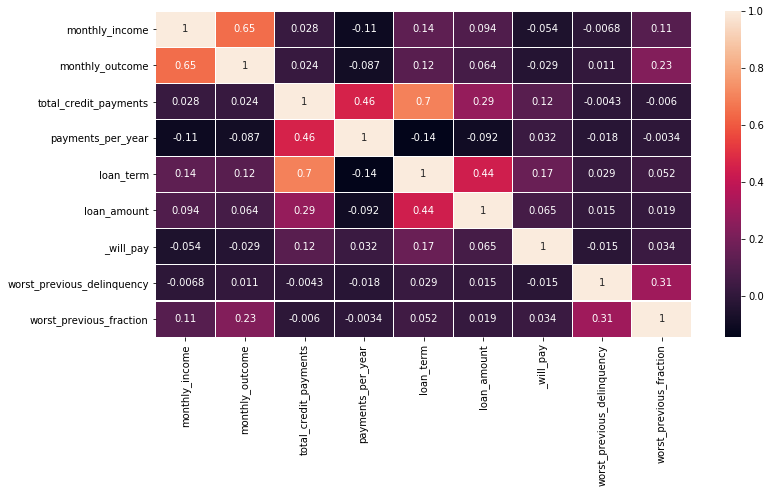

In [80]:
# Set-up figure
plt.figure(figsize=(12, 6))
# Correlation matrix
sns.heatmap(df.corr(), annot=True, linewidths=0.2)

# Categorical features

### account_opening_date

We create one bin open_recently that encodes this function (>recent_threhold). Future generalisations should 
group opening dates sistematically in order to improve modeling accuracy. 

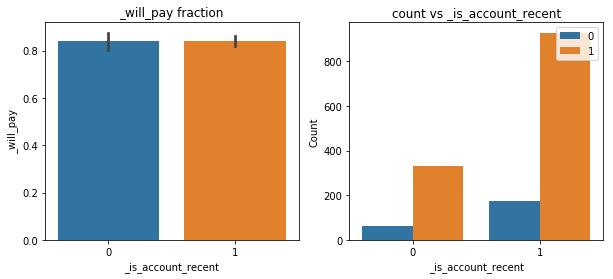

In [81]:
recent_threhold = 12  # 20XX

def turn_date_binary(col):
    date = int(col[0][-2:])
    if (date <= 18) & (date >= recent_threhold): return 1
    else: 
        return 0

df['_is_account_recent']=df[['account_opening_date']].apply(turn_date_binary, axis = 1)



def will_pay_and_count_vs(feature_str):
    """
    Arguments: 
    feature_str -- Categorica feature of df
    Return:
    Countplot -- For each label of feature_str
    Class Ratio plot -- For each value of feature_str
    """
    fig, ax = plt.subplots(1 , 2, figsize=(10, 4))
    
    
    axx=ax.flat

    g1=sns.catplot(x=feature_str,y='_will_pay',data=df,kind="bar",ax=axx[0])
    g1.set_ylabels("_will_pay")
    axx[0].set_title('_will_pay fraction')

    plt.close(2);
    axx[1]=sns.countplot(x = feature_str, hue = '_will_pay', data = df)
    axx[1].set_title('count vs '+feature_str)

    axx[1].set_xlabel(feature_str)
    axx[1].set_ylabel('Count')
    axx[1].legend(['0','1'],loc = 1)
    
    
will_pay_and_count_vs('_is_account_recent')

 #### Insights:
 These plots show that actually, the fraction passed our _will_pay test is independent
 of whether the clients account was opened recently or not. But most of our records
 have recent opening account date.

### credit_type

In [82]:
pd.value_counts(df.credit_type).to_frame()

,credit_type
Préstamo Personal,770
Aparatos - Muebles,199
Línea de Crédito,156
Compra de Automóvil,83
Crédito al Consumo,69
Crédito Fiscal,39
Préstamo de Nomina,33
Arrendamiento Automotriz,30
Otros (Múltiples Créditos),30
Grupo Solidario,17


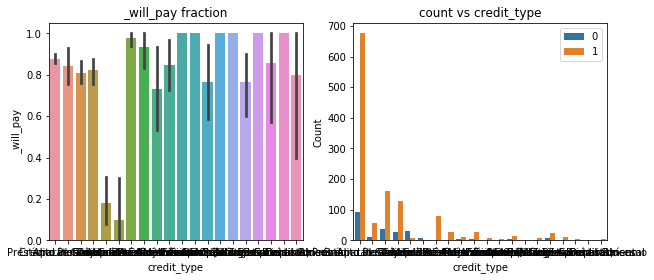

In [83]:
will_pay_and_count_vs('credit_type')

#### Insights:
From this plot it is clear that different credit types have different will_pay fractions. Further work
should aim to groups with similar ration/count values. For now we only single out the two common credit types: "Préstamo Personal". If we had a lot of data we could declare each type as variable, but in this case we would surely overfit. 

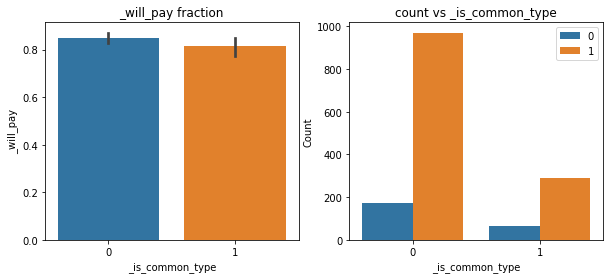

In [84]:
df['_is_common_type'] = ((df.credit_type=='Préstamo Personal') | (df.credit_type=='Línea de Crédito') | (df.credit_type=='Aparatos - Muebles')).astype(int)
will_pay_and_count_vs('_is_common_type')


# Numerical features

## monthly_income / monthly_outcome

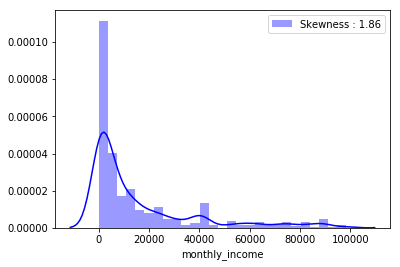

In [85]:
temp=df[df['monthly_income'] <100000 ]['monthly_income']
sns.distplot(temp, color="b", label="Skewness : %.2f"%(temp.skew())).legend(loc="best")

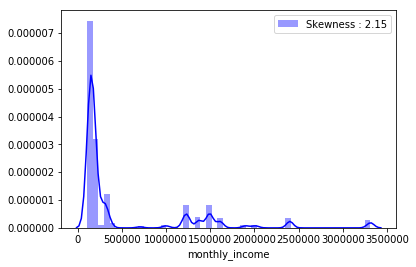

In [86]:
temp=df[(df['monthly_income'] >100000) ]['monthly_income']
sns.distplot(temp, color="b", label="Skewness : %.2f"%(temp.skew())).legend(loc="best")

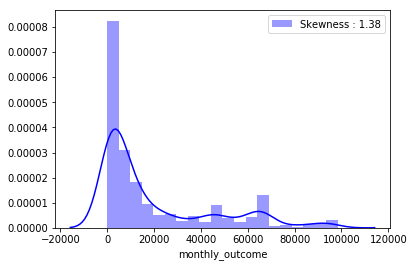

In [87]:
temp=df[df['monthly_outcome'] <100000 ]['monthly_outcome']
sns.distplot(temp, color="b", label="Skewness : %.2f"%(temp.skew())).legend(loc="best")

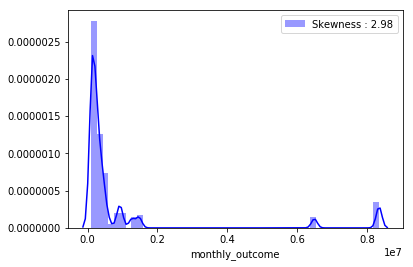

In [88]:
temp=df[(df['monthly_outcome'] >100000) ]['monthly_outcome']
sns.distplot(temp, color="b", label="Skewness : %.2f"%(temp.skew())).legend(loc="best")

In [89]:
# New features 

#ratio_outcome_income
df['ratio_outcome_income']= df['monthly_income']/df['monthly_outcome']

#sqrt  
df['sqrt_income']= df['monthly_income']**(1/2)
df['sqrt_outcome']= df['monthly_outcome']**(1/2)

#log
df['log_income']= df['monthly_income'].map(lambda i: np.log(i))
df['log_outcome']= df['monthly_outcome'].map(lambda i: np.log(i))

## Insights:

Income and outcome are highly concentrated at the oringin. But defintely have not bel shapes.
Indeed, many studies point out that wealth is not normally distributed. The role of the alternative 
variables sqrt and outcome will be postpone to the modeling stage, where we will study its importance.

## total_credit_payments

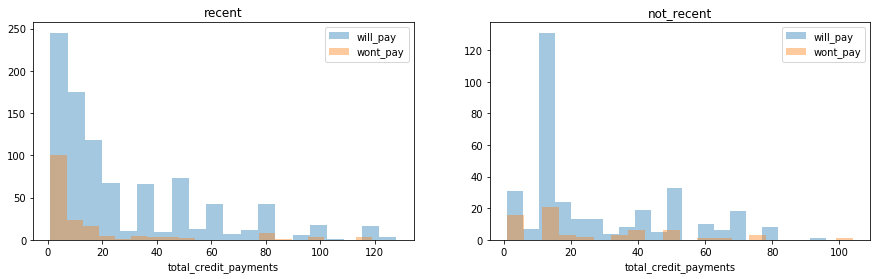

In [90]:


# Bar chart of total_credit_payments mapped against _will_pay. 
# For now, missing values would be dropped if the exist

survived = 'will_pay'
not_survived = 'wont_pay'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 4))
recent = df[df['_is_account_recent']==1]
notrecent = df[df['_is_account_recent']==0]

ax = sns.distplot(recent[recent['_will_pay']==1].total_credit_payments, bins=20, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(recent[recent['_will_pay']==0].total_credit_payments, bins=20, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('recent')
ax = sns.distplot(notrecent[notrecent['_will_pay']==1].total_credit_payments, bins=20, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(notrecent[notrecent['_will_pay']==0].total_credit_payments, bins=20, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('not_recent')


Text(0.5, 1.0, '_will_pay = 0')

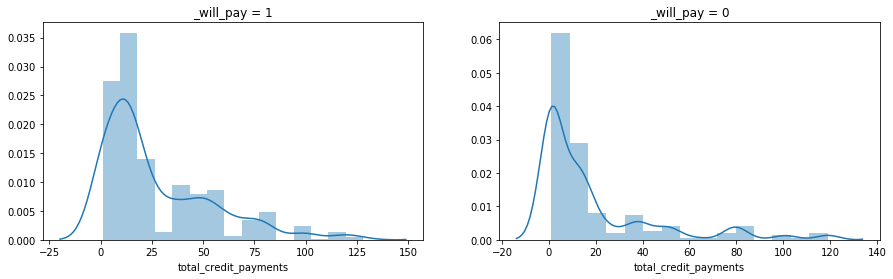

In [91]:

# Bar chart of total_credit_payments mapped against _will_pay. 
# For now, missing values would be dropped if the exist

survived = 'will_pay'
not_survived = 'wont_pay'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 4))

ax = sns.distplot(df[df['_will_pay']==1].total_credit_payments, bins=15, label = survived, ax = axes[0], kde = True)
ax.set_title('_will_pay = 1')

ax = sns.distplot(df[df['_will_pay']==0].total_credit_payments, bins=15, label = survived, ax = axes[1], kde = True)
ax.set_title('_will_pay = 0')

#### Insights

The distribution of the total payments is significantly different for people with will_pay=1 than
will_pay = 0. Observe that the highest correlation with _will_pay actually comes from thsi variable. It is
hard to tell if the distribution is Gaussian. 

## Further studies, should be applied to other variables in order to find the relationships between them and with the final variable. However, at this poitn I will jump to the modelling stage and only will come back once I have results.

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1497 entries, 38 to 16144
Data columns (total 18 columns):
monthly_income                1497 non-null int64
monthly_outcome               1497 non-null int64
credit_type                   1497 non-null object
total_credit_payments         1497 non-null float64
account_opening_date          1497 non-null object
payments_per_year             1497 non-null int64
loan_term                     1497 non-null float64
loan_amount                   1497 non-null float64
_will_pay                     1497 non-null int64
worst_previous_delinquency    1497 non-null float64
worst_previous_fraction       1497 non-null float64
_is_account_recent            1497 non-null int64
_is_common_type               1497 non-null int64
ratio_outcome_income          1497 non-null float64
sqrt_income                   1497 non-null float64
sqrt_outcome                  1497 non-null float64
log_income                    1497 non-null float64
log_outcome          

In [93]:
df.drop(columns =['credit_type','account_opening_date'], inplace = True)

In [94]:
df.describe()

,monthly_income,monthly_outcome,total_credit_payments,payments_per_year,loan_term,loan_amount,_will_pay,worst_previous_delinquency,worst_previous_fraction,_is_account_recent,_is_common_type,ratio_outcome_income,sqrt_income,sqrt_outcome,log_income,log_outcome
count,1.497000e+03,1.497000e+03,1497.000000,1497.000000,1497.000000,1.497000e+03,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000
mean,1.034017e+05,1.719674e+05,25.993988,24.138277,1.202957,4.809865e+04,0.841015,2537.717435,0.932389,0.736807,0.237141,19.654469,187.731390,211.177276,8.936118,9.356344
std,3.471559e+05,9.096811e+05,27.445022,16.518471,1.286824,1.704086e+05,0.365784,16369.770702,3.711050,0.440513,0.425472,105.172545,261.159329,357.010731,2.790555,2.349646
min,1.000000e+00,1.000000e+01,1.000000,1.000000,0.038462,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000466,1.000000,3.162278,0.000000,2.302585
25%,1.547000e+03,2.621000e+03,6.000000,12.000000,0.250000,2.000000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.224836,39.331921,51.195703,7.344073,7.871311
50%,1.062600e+04,1.179600e+04,14.000000,12.000000,1.000000,8.262000e+03,1.000000,0.000000,0.000000,1.000000,0.000000,0.737027,103.082491,108.609392,9.271059,9.375516
75%,5.431100e+04,6.374300e+04,39.000000,26.000000,1.500000,3.007000e+04,1.000000,438.000000,0.115385,1.000000,0.000000,2.021178,233.047206,252.473761,10.902482,11.062615
max,3.313847e+06,8.350141e+06,128.000000,52.000000,5.000000,5.056561e+06,1.000000,321976.000000,24.000000,1.000000,1.000000,1335.000000,1820.397484,2889.661053,15.013620,15.937789


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1497 entries, 38 to 16144
Data columns (total 16 columns):
monthly_income                1497 non-null int64
monthly_outcome               1497 non-null int64
total_credit_payments         1497 non-null float64
payments_per_year             1497 non-null int64
loan_term                     1497 non-null float64
loan_amount                   1497 non-null float64
_will_pay                     1497 non-null int64
worst_previous_delinquency    1497 non-null float64
worst_previous_fraction       1497 non-null float64
_is_account_recent            1497 non-null int64
_is_common_type               1497 non-null int64
ratio_outcome_income          1497 non-null float64
sqrt_income                   1497 non-null float64
sqrt_outcome                  1497 non-null float64
log_income                    1497 non-null float64
log_outcome                   1497 non-null float64
dtypes: float64(10), int64(6)
memory usage: 238.8 KB


In [96]:
df.to_csv('./dataset/data_prepared.csv')